# EEG Preprocessing Pipeline

## Overview
This notebook implements a comprehensive EEG preprocessing pipeline using MNE-Python. It processes raw EEG data through multiple stages including filtering, bad channel detection, artifact removal, and epoch extraction.

## Pipeline Steps

1. **Data Loading** - Loads raw EEG files and behavioral/trigger data
2. **Montage Setup** - Configures electrode positions and channel types (EEG, EOG)
3. **Trigger Processing** - Converts triggers to annotations and removes training periods
4. **Signal Cropping** - Trims data to relevant time windows around events
5. **Filtering** - Applies bandpass filter to remove noise and drifts
6. **Bad Channel Detection** - Identifies noisy channels using PyPREP (with optional RANSAC)
7. **Re-referencing** - Sets average reference across all EEG channels
8. **Ocular Artifact Removal** - Removes eye movement artifacts using EOG regression
9. **Channel Interpolation** - Interpolates previously identified bad channels
10. **Epoching** - Segments continuous data into event-locked epochs
11. **Automatic Artifact Rejection** - Uses AutoReject to identify and repair/reject bad epochs

## Key Dependencies

- **MNE-Python** - Core EEG processing library
- **PyPREP** - Bad channel detection
- **AutoReject** - Automated epoch rejection and repair
- **pandas** - Trigger file handling

## Configuration Parameters

All preprocessing parameters are defined in the Configuration section and can be adjusted:
- File paths (input/output directories)
- Electrode montage type
- Filter cutoffs
- Epoch time windows
- AutoReject hyperparameters
- Output options (saving, plotting)

## Output

Preprocessed epochs are saved as FIF files with metadata (participant ID, sex, age) in the filename.

In [15]:
import mne
from mne.preprocessing import EOGRegression
from tqdm import tqdm
from pyprep.find_noisy_channels import NoisyChannels
import os
import sys
import numpy as np
import pandas as pd
from autoreject import AutoReject

from src.load_data import prepare_files_info
from src.utils import write
from src.triggers import set_annotations_from_trigger_file, drop_training_annotations
from src.epochs import create_epochs

# matplotlib.use('TkAgg')
mne.set_log_level('ERROR')

### Configuration

In [16]:
# Paths to data folders
BEH_PATH = "BEH" # Path to the folder with behavioral data files.
EEG_PATH = "EEG" # Path to the folder with raw EEG data files.
RESULT_PATH = "PREPROCESSED" # Path to the folder where preprocessed data will be saved.

# Electrode montage settings
MONTAGE = "biosemi64" # Name of the EEG electrode montage used in the recording (e.g., "biosemi64").

# Signal cropping settings
START_CUT_EXTRA_TIME = 2 # Extra time (in seconds) kept before the first event/trigger.
END_CUT_EXTRA_TIME = 2 # Extra time (in seconds) kept after the last event/trigger.

# Filtering settings
LOW_PASS = 0.5 # High‑pass filter cutoff frequency in Hz (removes very slow drifts).
HIGH_PASS = 48 # Low‑pass filter cutoff frequency in Hz (removes high‑frequency noise).

# Bad channel detection (PyPREP)
RANSAC = True # Whether to use the RANSAC algorithm for robust bad channel detection.
SEED = 42 # Random seed to ensure reproducible results.

# Epoching settings
EPOCHS_LEN = [0, 2] # Epoch time window [tmin, tmax] in seconds relative to event onset.
TRIGGER_TYPE = "experiment_mask" # Type/name of triggers used to create epochs.

# AutoReject settings (automatic artifact rejection for epochs)
INTERPOLATION = [16] # Number of channels to interpolate when repairing bad epochs.
CONSENSUS = None # Consensus percentage for rejecting epochs (None = let AutoReject choose).
METHOD = 'bayesian_optimization' # Strategy for optimizing rejection thresholds.
N_JOBS = 1 # Number of parallel jobs used by AutoReject.
CV = 10 # Number of cross‑validation folds used by AutoReject.

# ROI
ROI_FRONTAL = ["AFz", "Fz", "FCz", "F1", "F2", "FC1", "FC2"]
ROI_POSTERIOR = ["CPz", "Pz", "POz", "P1", "P2"]

# Output and visualization settings
SAVE_DATA = True # If True, save preprocessed epochs to disk as FIF files.
OVERWRITE_DATA = False
WRITE_INFO = True # If True, print textual progress and summary information.
PLOT_INFO = True # If True, show diagnostic plots (e.g., rejected epochs, reject_log).

### Parameters

In [17]:
DATA = prepare_files_info(eeg_path=EEG_PATH, beh_path=BEH_PATH)

### Preprocessing

  0%|          | 0/30 [00:00<?, ?it/s]

ET0102
File already exists
FZ0107
File already exists
GK2402
File already exists
GL1210
File already exists
GL2007
File already exists
GW0407
bad channels: ['P2', 'P1', 'Pz', np.str_('P3'), np.str_('POz')]
interpolated 5 channels
Created 60 epochs (2.000 s) for 'experiment_mask'
Number of epochs: 60
Number of rejected epochs: 0


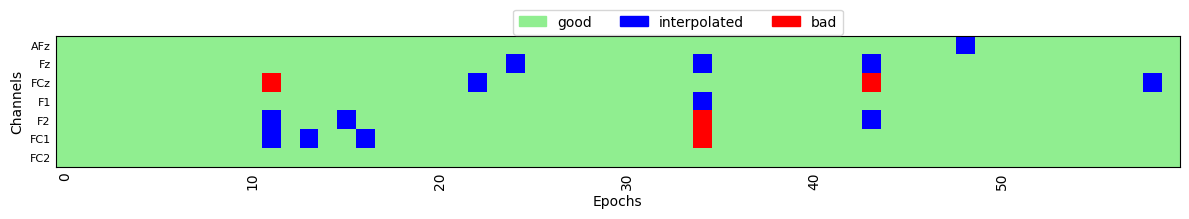

Data saved to GW0407_F_20_preprocessed-epo.fif


 20%|██        | 6/30 [01:30<06:02, 15.09s/it]

GZ1103
bad channels: ['Iz', 'P1', np.str_('CP4')]
interpolated 3 channels
Created 59 epochs (2.000 s) for 'experiment_mask'
Number of epochs: 58
Number of rejected epochs: 1


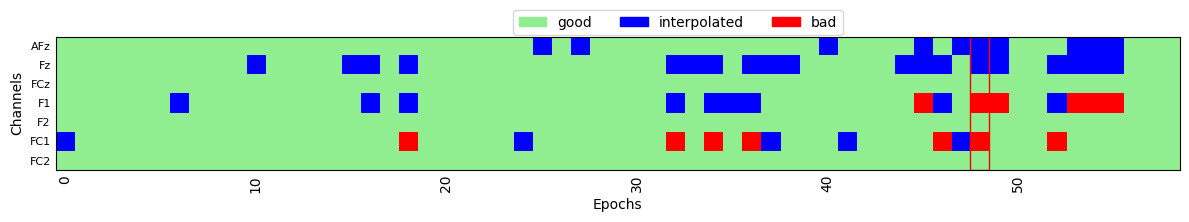

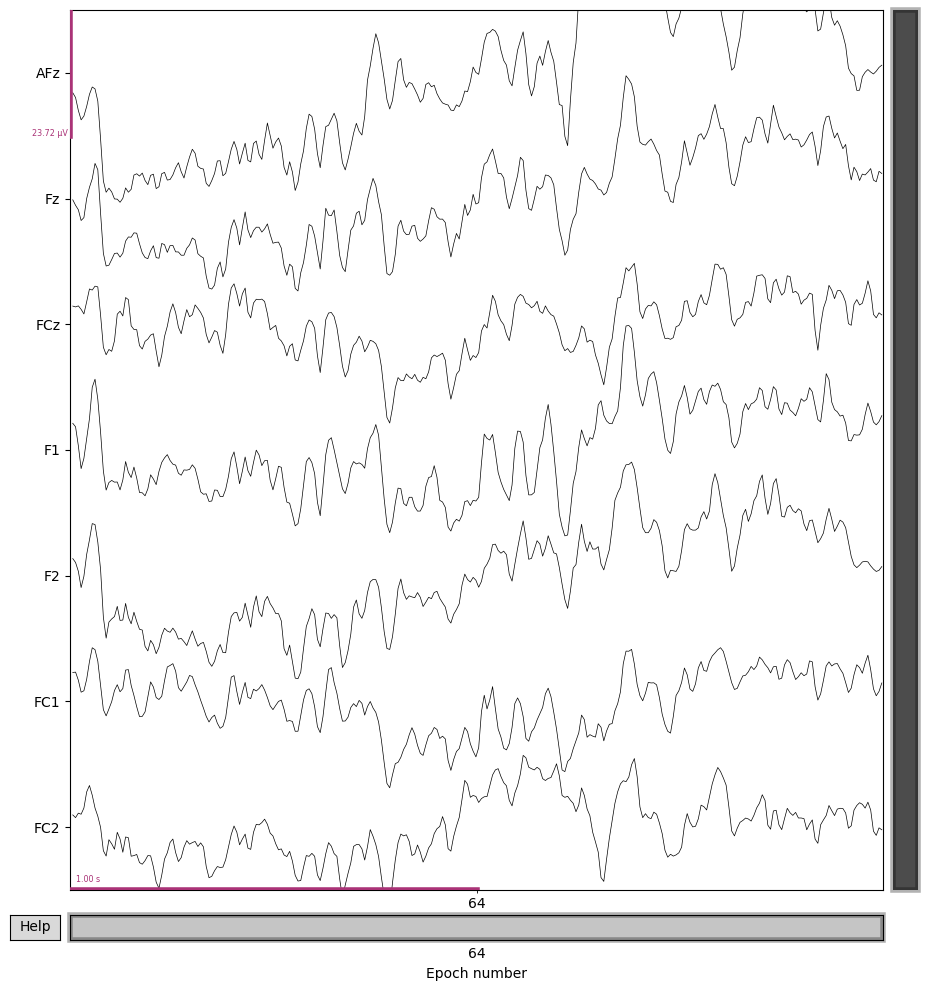

Data saved to GZ1103_F_27_preprocessed-epo.fif


 23%|██▎       | 7/30 [03:05<11:38, 30.38s/it]

HB0712
bad channels: ['P2', 'P1', 'POz', 'Pz']
interpolated 4 channels
Created 57 epochs (2.000 s) for 'experiment_mask'
Number of epochs: 57
Number of rejected epochs: 0


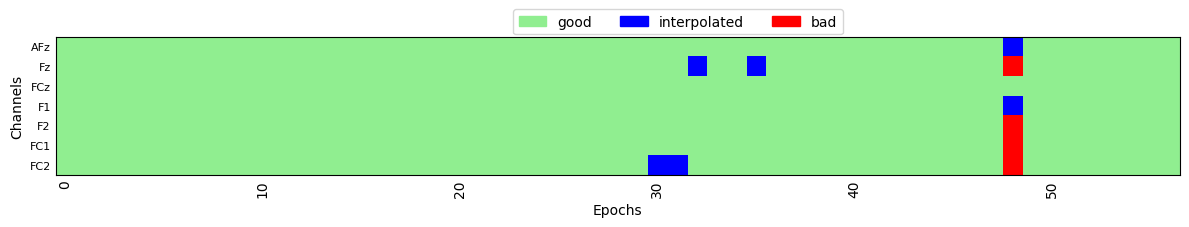

Data saved to HB0712_F_20_preprocessed-epo.fif


 27%|██▋       | 8/30 [04:33<15:44, 42.93s/it]

HP1505
bad channels: ['O2', 'Oz', np.str_('POz'), 'PO3']
interpolated 4 channels
Created 57 epochs (2.000 s) for 'experiment_mask'
Number of epochs: 56
Number of rejected epochs: 1


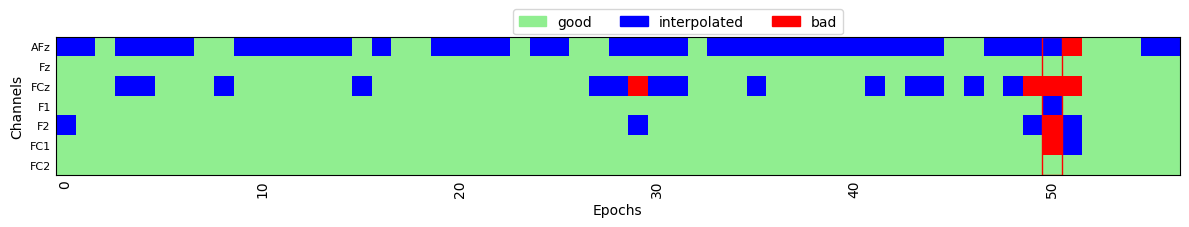

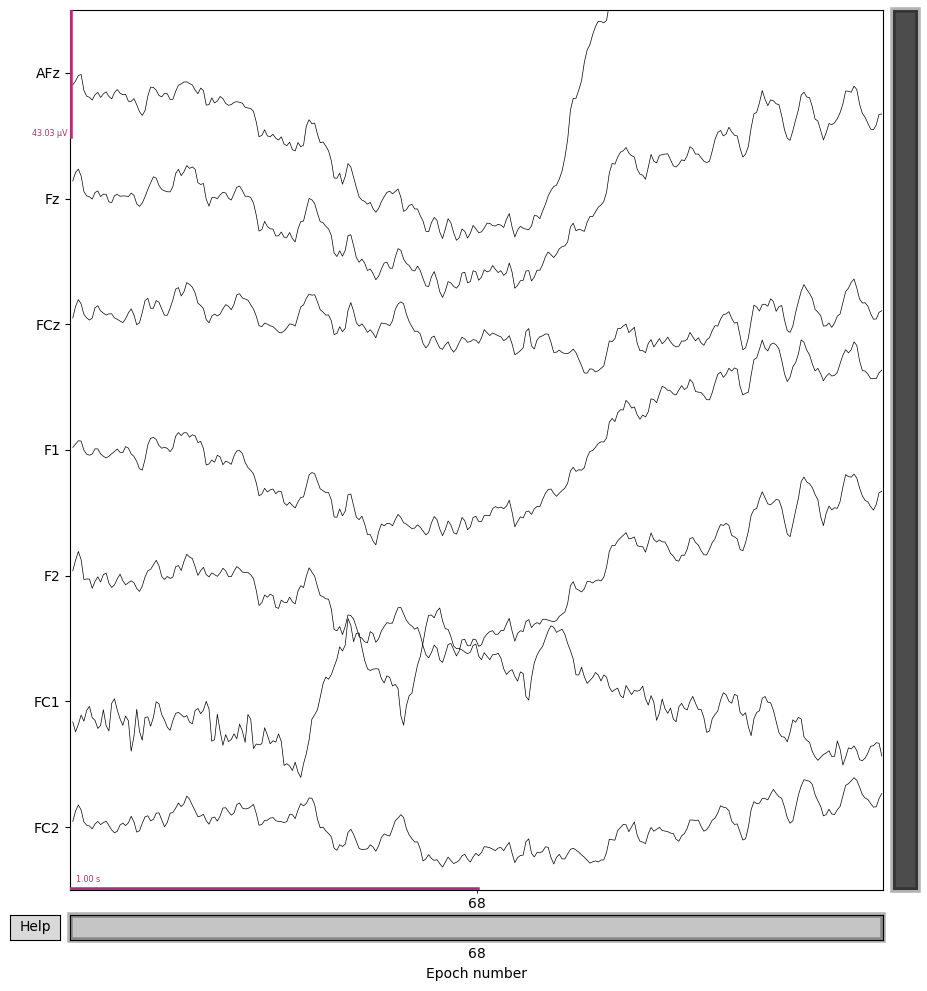

Data saved to HP1505_M_23_preprocessed-epo.fif


 30%|███       | 9/30 [06:01<18:45, 53.59s/it]

HZ1304
bad channels: ['P2', 'P1', 'PO3', 'P3']
interpolated 4 channels
Created 61 epochs (2.000 s) for 'experiment_mask'
Number of epochs: 47
Number of rejected epochs: 14


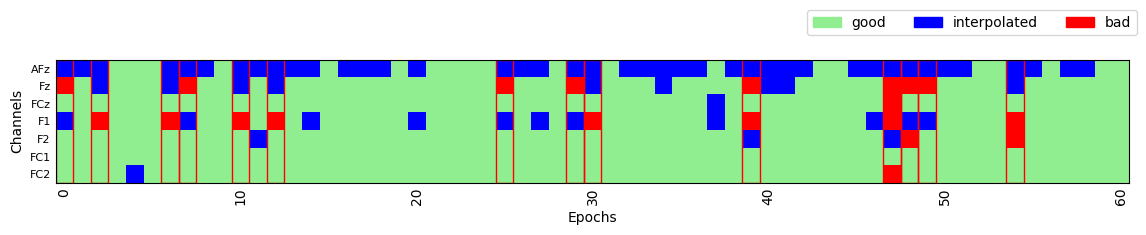

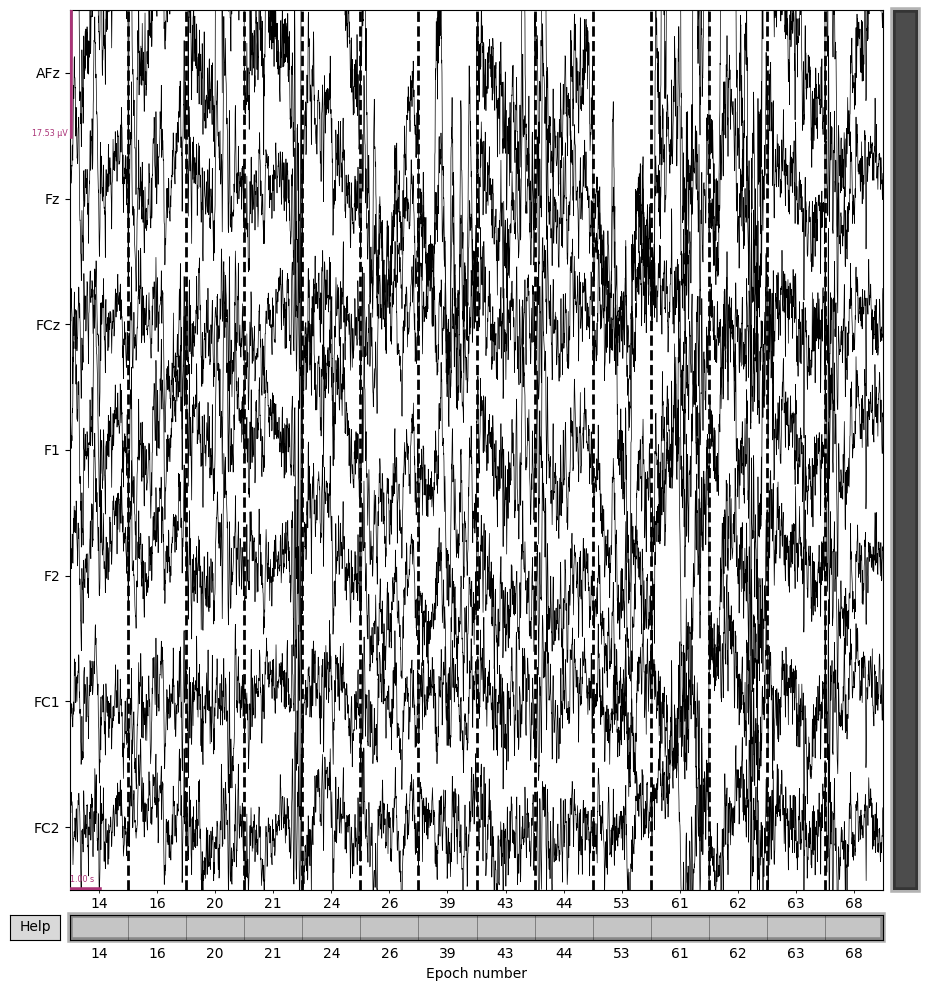

Data saved to HZ1304_F_29_preprocessed-epo.fif


 33%|███▎      | 10/30 [07:35<21:10, 63.53s/it]

IZ2310
bad channels: ['P1', 'PO3', 'P3', 'POz']
interpolated 4 channels
Created 61 epochs (2.000 s) for 'experiment_mask'
Number of epochs: 61
Number of rejected epochs: 0


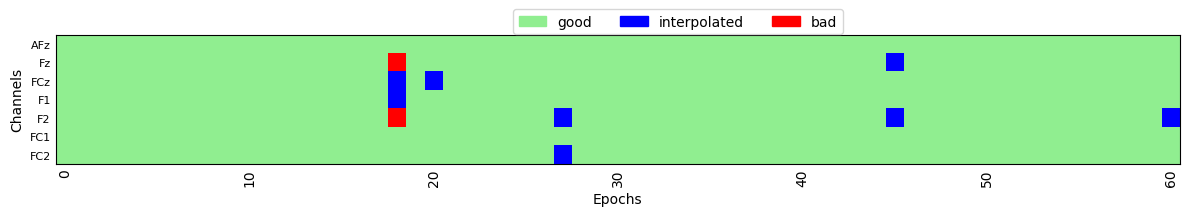

Data saved to IZ2310_F_21_preprocessed-epo.fif


 37%|███▋      | 11/30 [08:58<21:49, 68.93s/it]

JA0310
bad channels: ['P7', 'P9', np.str_('PO8'), np.str_('P8'), 'Iz', 'PO3', np.str_('PO7')]
interpolated 7 channels
Created 60 epochs (2.000 s) for 'experiment_mask'
Number of epochs: 60
Number of rejected epochs: 0


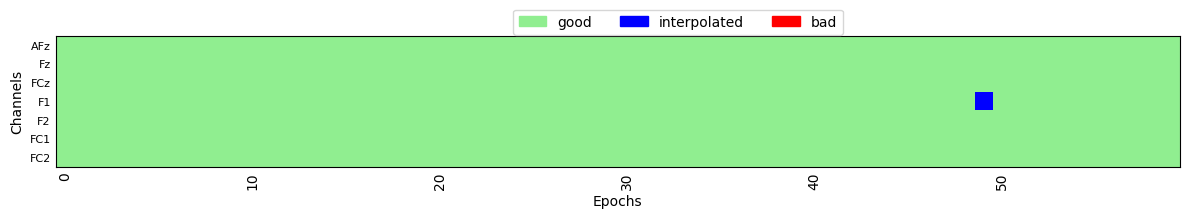

Data saved to JA0310_F_20_preprocessed-epo.fif


 40%|████      | 12/30 [10:29<22:28, 74.90s/it]

JB0612
bad channels: ['P1', 'POz', 'Pz']
interpolated 3 channels
Created 59 epochs (2.000 s) for 'experiment_mask'
Number of epochs: 59
Number of rejected epochs: 0


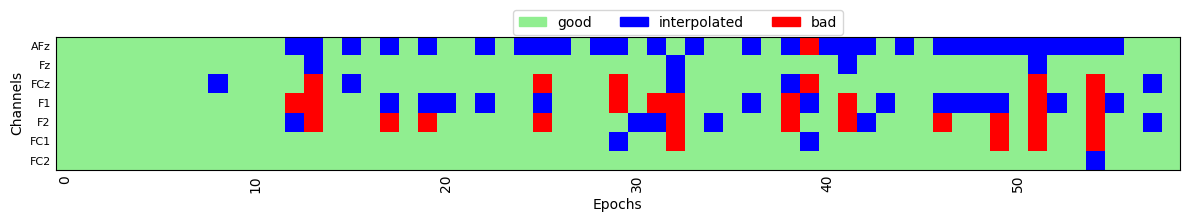

Data saved to JB0612_F_20_preprocessed-epo.fif


 43%|████▎     | 13/30 [11:54<22:01, 77.74s/it]

JB1302
bad channels: ['POz', 'PO3']
interpolated 2 channels
Created 61 epochs (2.000 s) for 'experiment_mask'
Number of epochs: 46
Number of rejected epochs: 15


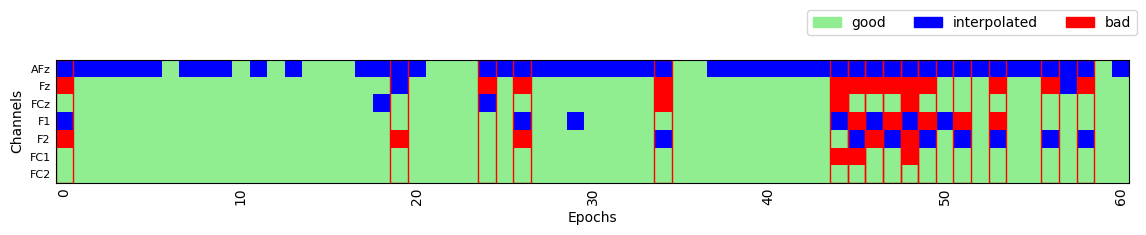

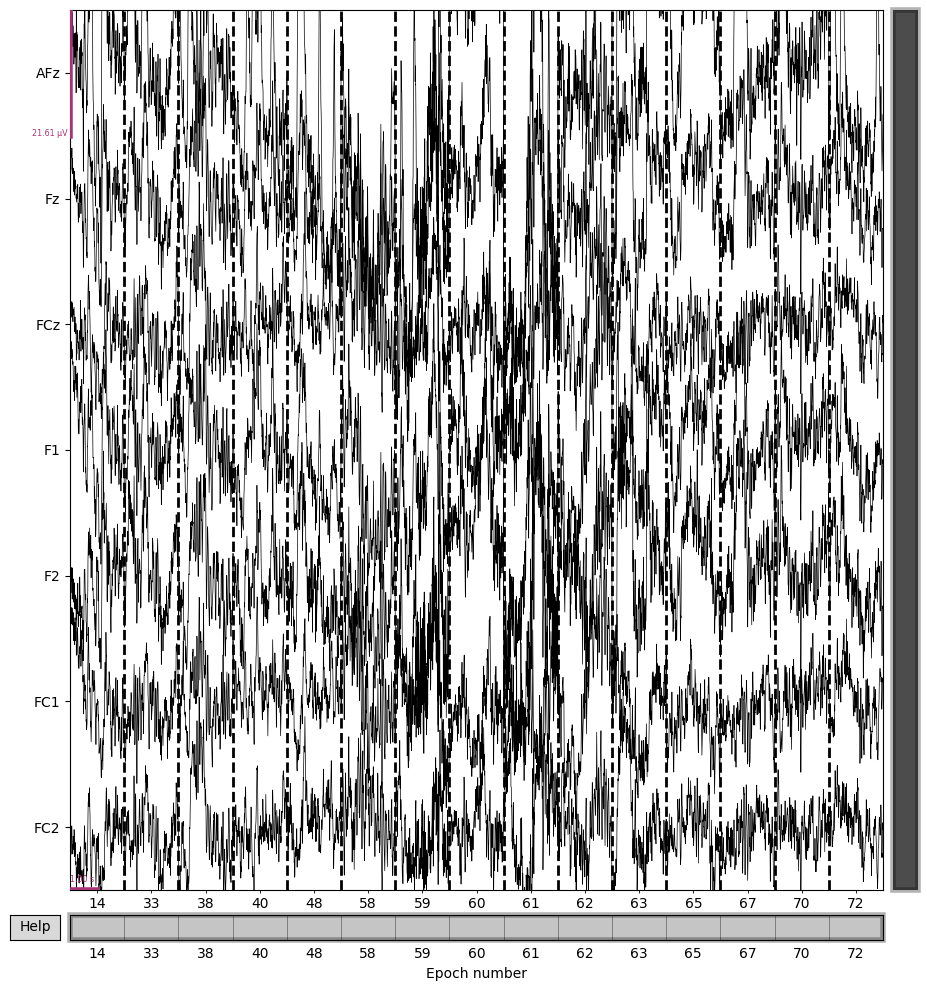

Data saved to JB1302_F_23_preprocessed-epo.fif


 47%|████▋     | 14/30 [13:24<21:41, 81.32s/it]

JB2202
bad channels: ['P2', 'P1', np.str_('Pz'), 'PO4']
interpolated 4 channels
Created 59 epochs (2.000 s) for 'experiment_mask'
Number of epochs: 59
Number of rejected epochs: 0


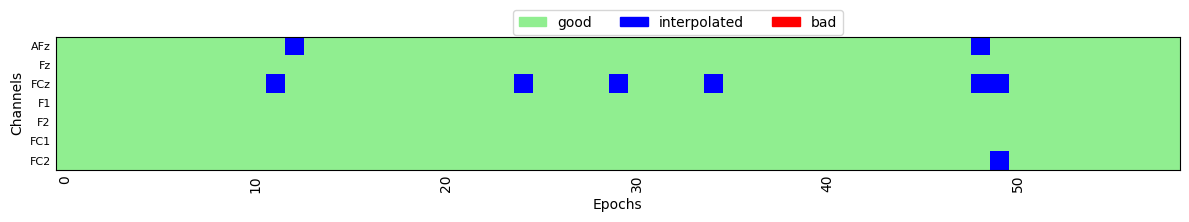

Data saved to JB2202_F_19_preprocessed-epo.fif


 50%|█████     | 15/30 [14:45<20:14, 80.99s/it]

JC1301
bad channels: ['POz']
interpolated 1 channels
Created 56 epochs (2.000 s) for 'experiment_mask'
Number of epochs: 52
Number of rejected epochs: 4


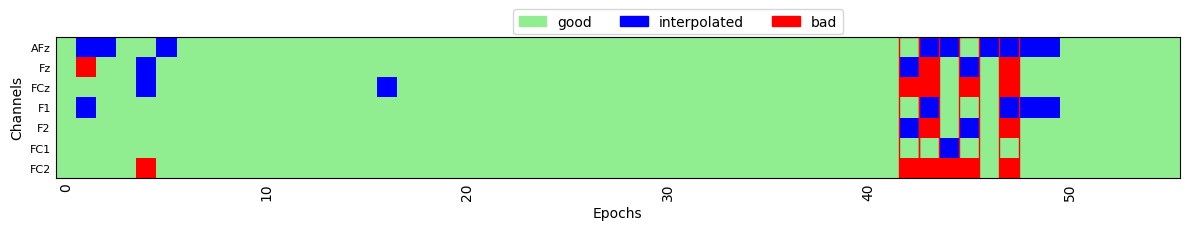

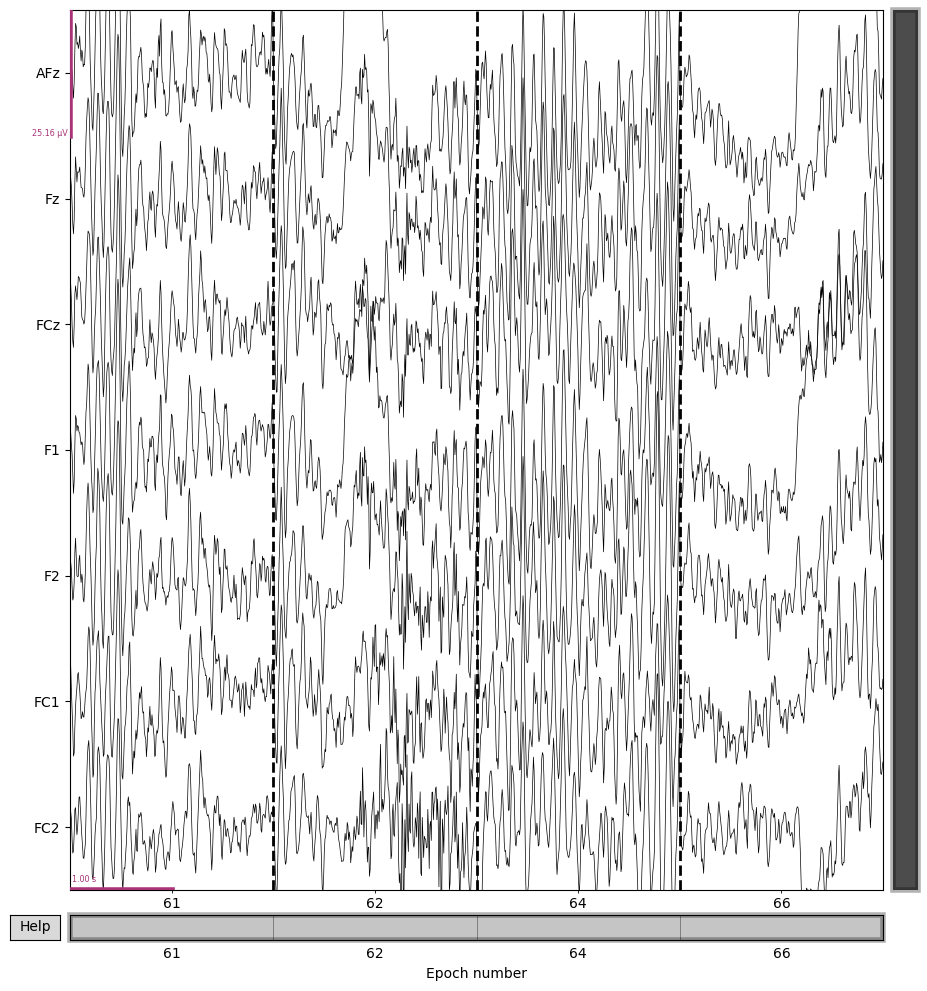

Data saved to JC1301_M_21_preprocessed-epo.fif


 53%|█████▎    | 16/30 [16:11<19:16, 82.58s/it]

JD0609
bad channels: ['P1', np.str_('Pz'), 'PO4', np.str_('POz'), 'C1']
interpolated 5 channels
Created 58 epochs (2.000 s) for 'experiment_mask'
Number of epochs: 58
Number of rejected epochs: 0


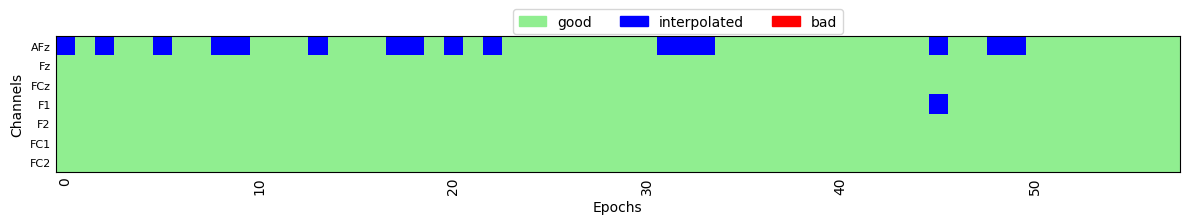

Data saved to JD0609_F_20_preprocessed-epo.fif


 57%|█████▋    | 17/30 [17:41<18:20, 84.63s/it]

JD0705
bad channels: ['P1', 'Pz', 'POz', 'P4', 'PO3', 'O1']
interpolated 6 channels
Created 62 epochs (2.000 s) for 'experiment_mask'
Number of epochs: 61
Number of rejected epochs: 1


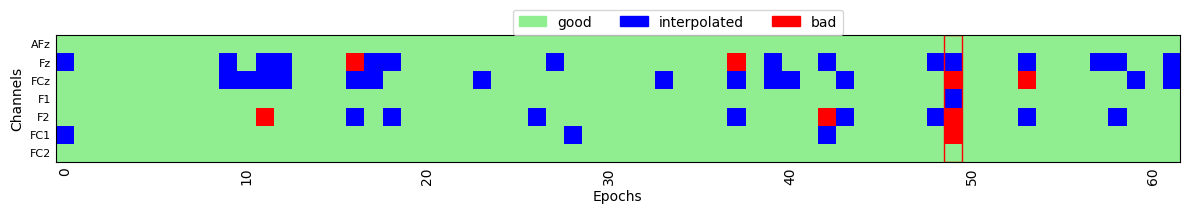

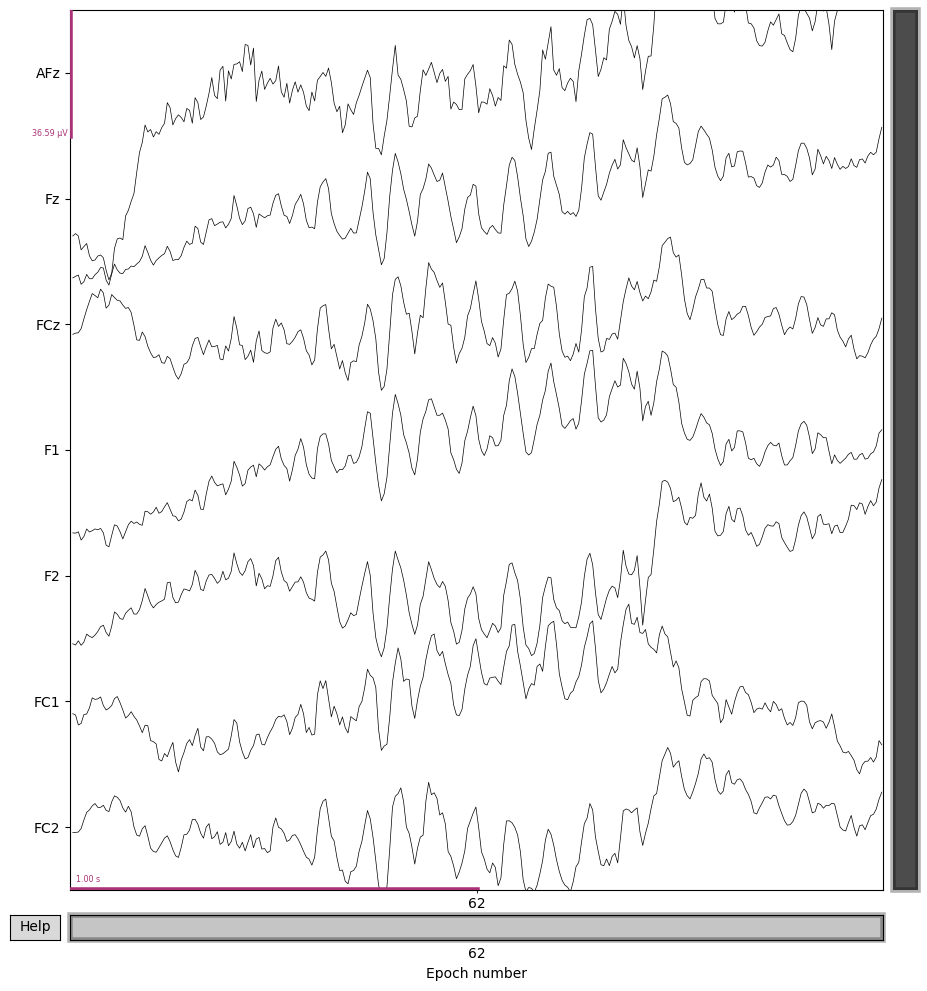

Data saved to JD0705_F_18_preprocessed-epo.fif


 60%|██████    | 18/30 [19:03<16:46, 83.90s/it]

JD2604
bad channels: ['PO3', np.str_('TP8'), 'POz', 'P9']
interpolated 4 channels
Created 60 epochs (2.000 s) for 'experiment_mask'
Number of epochs: 57
Number of rejected epochs: 3


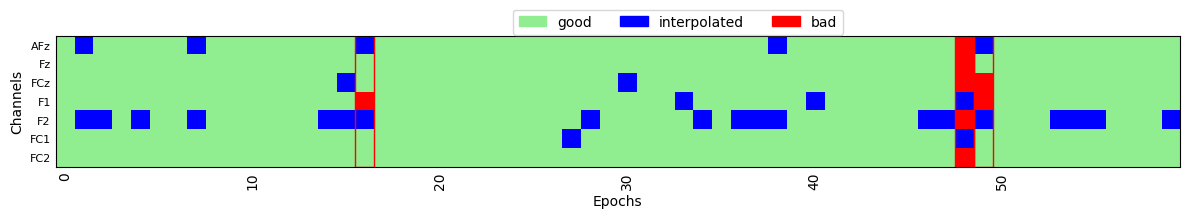

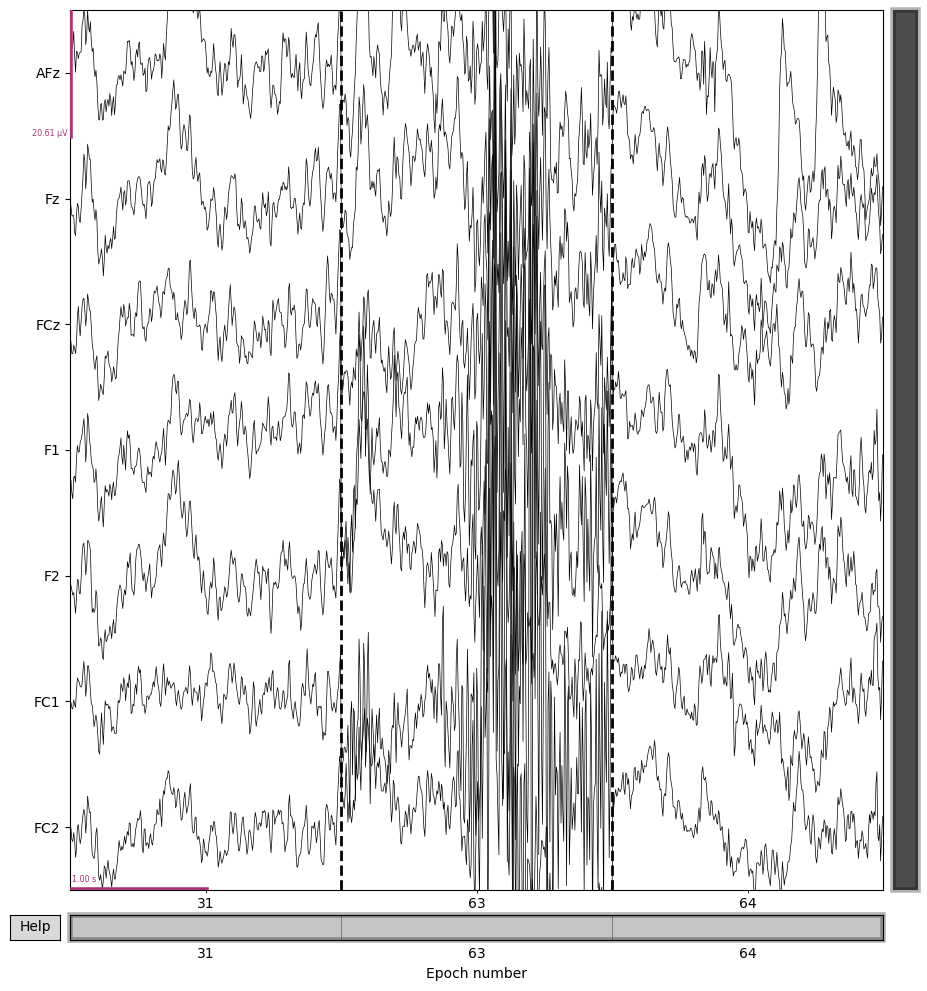

Data saved to JD2604_M_21_preprocessed-epo.fif


 63%|██████▎   | 19/30 [20:25<15:16, 83.35s/it]

JF0212
bad channels: ['POz', np.str_('Pz')]
interpolated 2 channels
Created 62 epochs (2.000 s) for 'experiment_mask'
Number of epochs: 62
Number of rejected epochs: 0


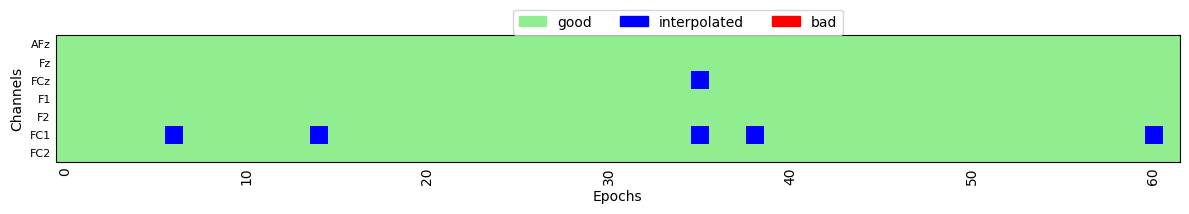

Data saved to JF0212_F_20_preprocessed-epo.fif


100%|██████████| 30/30 [21:58<00:00, 43.95s/it]

PZ1301
File already exists
RB0810
File already exists
RS2510
File already exists
SK2709
File already exists
SL2812
File already exists
SM2910
File already exists
SR1601
File already exists
TT2311
File already exists
VT0608
File already exists
WB0308
File already exists


In [18]:
for part in tqdm(DATA):
    write(part['ID'], WRITE_INFO)
    file_name = f"{part['ID']}_{part['sex']}_{part['age']}_preprocessed-epo.fif"
    if not OVERWRITE_DATA and file_name in os.listdir(RESULT_PATH):
        write("File already exists", WRITE_INFO)
        continue
    # --- load eeg ---
    raw = mne.io.read_raw(part['eeg_file'], preload=True, verbose=False)
    trigg_df = pd.read_csv(part['trigg_file'], comment='#')

    # --- montage ---
    eog_channels = {f'EXG{i}': 'eog' for i in range(1, 5) if f'EXG{i}' in raw.ch_names}
    if eog_channels:
        raw.set_channel_types(eog_channels)
    drop_channels = [f'EXG{i}' for i in range(5, 9) if f'EXG{i}' in raw.ch_names]
    if drop_channels:
        raw.drop_channels(drop_channels)
    raw.set_montage(MONTAGE, on_missing='warn')

    # --- change triggers to annotation and rename them
    raw = set_annotations_from_trigger_file(raw, trigg_df, write_info=WRITE_INFO)
    if raw is None:
        sys.stdout.flush() # for correct order of printed text when using tqdm
        continue

    # --- remove training ---
    raw = drop_training_annotations(raw)

    # --- crop signal ---
    times = raw.annotations.onset
    start_cut = max(0, times[0] - START_CUT_EXTRA_TIME)
    end_cut = min(raw.times[-1], times[-1] + END_CUT_EXTRA_TIME)
    raw.crop(start_cut, end_cut)
    raw.annotations.onset -= start_cut

    # --- filter ---
    raw.filter(l_freq=LOW_PASS, h_freq=HIGH_PASS, picks="eeg", verbose=False)

    # --- find and mark bad channels ---
    nc = NoisyChannels(raw, ransac=RANSAC, do_detrend=False, random_state=SEED)
    nc.find_all_bads()
    raw.info['bads'] = nc.get_bads()
    write(f"bad channels: {raw.info['bads']}", WRITE_INFO)

    # --- set reference ---
    raw.set_eeg_reference("average", verbose=False)

    # --- remove ocular artifacts ---
    model_plain = EOGRegression(picks="eeg", exclude="bads", picks_artifact="eog").fit(raw)
    raw = model_plain.apply(raw, copy=True)

    # --- interpolate bad channels ---
    if len(raw.info['bads']) > 0:
        raw.interpolate_bads(reset_bads=True, verbose=False)
        write(f"interpolated {len(nc.get_bads())} channels", WRITE_INFO)

    # --- create epochs ---
    epochs = create_epochs(raw, trigger_type=TRIGGER_TYPE, tmin=EPOCHS_LEN[0],
                           tmax=EPOCHS_LEN[1], write_info=WRITE_INFO)
    epochs.pick_channels(ROI_FRONTAL)
    #epochs.resample(256)
    if PLOT_INFO:
        epochs_original = epochs.copy()

    # --- remove epochs with artifacts ---
    ar = AutoReject(
            n_interpolate=[2],
            consensus=CONSENSUS,
            thresh_method=METHOD,
            n_jobs=N_JOBS,
            cv = CV,
            random_state=SEED,
            verbose=False)

    epochs, reject_log = ar.fit_transform(epochs, return_log=True)
    write(f"Number of epochs: {len(epochs)}", WRITE_INFO)
    write(f"Number of rejected epochs: {reject_log.bad_epochs.sum()}", WRITE_INFO)

    # --- Plot removed epochs ---
    if PLOT_INFO:
        reject_log.plot('horizontal')
        bad_epochs_idx = np.where(reject_log.bad_epochs)[0] # Bad epoch index
        if 0 < len(bad_epochs_idx) < 20:
            epochs_original[bad_epochs_idx].plot(n_epochs=len(bad_epochs_idx),
                                                  n_channels=64,
                                                  scalings='auto',
                                                  title='Odrzucone epoki')


    # --- Save data ---
    if SAVE_DATA:

        epochs.save(os.path.join(RESULT_PATH, file_name), verbose=False, overwrite=True)
        write(f"Data saved to {file_name}", WRITE_INFO)

    sys.stdout.flush() # for correct order of printed text when using tqdm


In [19]:
# import numpy as np
# import matplotlib.pyplot as plt
#
# # Zdefiniuj swoje ROI
# ROI_FRONTAL = ['AFz', 'Fz', 'FCz', 'F1', 'F2', 'FC1', 'FC2']
#
# # Pobierz nazwy wszystkich kanałów z epochs
# all_ch_names = epochs.ch_names
#
# # Znajdź indeksy kanałów z ROI_FRONTAL
# roi_indices = [i for i, ch in enumerate(all_ch_names) if ch in ROI_FRONTAL]
#
# # Sprawdź, które kanały znalazłeś
# roi_ch_names = [all_ch_names[i] for i in roi_indices]
# print(f"Kanały w ROI_FRONTAL: {roi_ch_names}")
#
#
# # Filtruj labels (macierz epoki × kanały)
# # labels: 0 = good, 1 = bad, 2 = interpolated
# reject_log.labels = reject_log.labels[:, roi_indices]
#
# # Filtruj ch_names
# reject_log.ch_names = roi_ch_names
#
# # Teraz narysuj tylko dla ROI
# fig = reject_log.plot('horizontal')
# plt.show()